# MA336: Artificial intelligence and machine learning with applications

# Reg No: 2320942

# Predicting Game Playtime and Recommending Games to User using Machine Learning.

## Introduction

Welcome to our project, where we predict game playtime and recommend games using machine learning! The analysis in this report delves into a rich dataset of over 41 million cleaned and preprocessed user recommendations (reviews) from the Steam store. Steam store is a leading online platform for purchasing and downloading video games, DLC, and other gaming-related content. 

The fascinating world of (PC) games leads to some meaningful and really great insights about a user's persona and playing pattern. We aim to understand how people play games and what they like by looking at data from user reviews and game details. By using machine learning algorithms, we can predict how long someone may play a game and suggest new games they may enjoy.

This information helps Steam provide better game recommendations, making users happier and increasing sales. By analyzing this data, Steam can improve its recommendation system, leading to more satisfied customers and higher revenue. Machine learning turns this vast amount of data into useful insights that benefit both users and the platform. Steam Store can utilise this data at a much higher extent to increase their revenues and in-turn their growth.

## Dataset

Link for the Dataset is as follow:
https://www.kaggle.com/datasets/antonkozyriev/game-recommendations-on-steam

#### Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.cluster import KMeans
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
import warnings
warnings.filterwarnings('ignore')

## Exploration of data (EDA)

While exploring the data, we'll use a bunch of reviews to see how long people play games and what kind of games they like. We'll look at things like how long people play different types of games, how ratings affect playtime, and if people who write similar reviews play similar games. This will help us build a system to recommend games that user loves!

**Playtime Patterns:**

- **Short bursts or marathon sessions?** We'll investigate playtime distribution across games to see if users favor quick bursts or longer playthroughs.

- **Genre matters?** We'll analyze playtime variations based on game genres. Do users spend more time on specific types of games? Does platform (Windows, Mac, Linux) influence playtime?

- **Ratings and Reviews as playtime predictors?** We'll explore if playtime correlates with user ratings and review counts. Do people spend more time on highly-rated or more-discussed games?

The main objective in this report is to navigate through this data, uncovering the pattern and trends that can help us understand how users play games and what types of games they enjoy the most.

 We will explore **four datasets** in our report. Below is their information:

In [2]:
# Load datasets
games = pd.read_csv('/Users/shraddha/Desktop/AI/datasets/games.csv')
games_metadata = pd.read_json(r'/Users/shraddha/Desktop/AI/datasets/games_metadata.json',lines=True)
recommendations = pd.read_csv('/Users/shraddha/Desktop/AI/datasets/recommendations.csv')
users = pd.read_csv('/Users/shraddha/Desktop/AI/datasets/users.csv')

- **games.csv**: Captures game details like title, release date, platform support, rating, user reviews (not provided), price, and Steam Deck compatibility.

In [3]:
games.head()

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck
0,13500,Prince of Persia: Warrior Within™,2008-11-21,True,False,False,Very Positive,84,2199,9.99,9.99,0.0,True
1,22364,BRINK: Agents of Change,2011-08-03,True,False,False,Positive,85,21,2.99,2.99,0.0,True
2,113020,Monaco: What's Yours Is Mine,2013-04-24,True,True,True,Very Positive,92,3722,14.99,14.99,0.0,True
3,226560,Escape Dead Island,2014-11-18,True,False,False,Mixed,61,873,14.99,14.99,0.0,True
4,249050,Dungeon of the ENDLESS™,2014-10-27,True,True,False,Very Positive,88,8784,11.99,11.99,0.0,True


- **games_metadata.json**: Provides textual descriptions and genre tags associated with each game.

In [4]:
games_metadata.head()

,app_id,description,tags
0,13500,Enter the dark underworld of Prince of Persia ...,"[Action, Adventure, Parkour, Third Person, Gre..."
1,22364,,[Action]
2,113020,Monaco: What's Yours Is Mine is a single playe...,"[Co-op, Stealth, Indie, Heist, Local Co-Op, St..."
3,226560,Escape Dead Island is a Survival-Mystery adven...,"[Zombies, Adventure, Survival, Action, Third P..."
4,249050,Dungeon of the Endless is a Rogue-Like Dungeon...,"[Roguelike, Strategy, Tower Defense, Pixel Gra..."


- **recommendation.csv**: Captures user recommendations, including helpfulness, humor ratings, recommendation status, playtime, user ID, review ID for the recommendation, and the recommended app ID.

In [5]:
recommendations.head()

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id
0,975370,0,0,2022-12-12,True,36.3,51580,0
1,304390,4,0,2017-02-17,False,11.5,2586,1
2,1085660,2,0,2019-11-17,True,336.5,253880,2
3,703080,0,0,2022-09-23,True,27.4,259432,3
4,526870,0,0,2021-01-10,True,7.9,23869,4


- **users.csv**: Contains anonymized user IDs and their total game purchases and reviews.

In [6]:
users.head()

,user_id,products,reviews
0,7360263,359,0
1,14020781,156,1
2,8762579,329,4
3,4820647,176,4
4,5167327,98,2


As we are reading the json file we are cross-verifying that the **'tags'** are in the list, if it is not then it will convert them into list.

In [7]:
# Function to convert tags to list if necessary
def convert_tags_to_list(tags):
    if isinstance(tags, str):
        return tags.strip('[]').replace("'", "").split(', ')
    return tags

# Apply the conversion function to the 'tags' column
games_metadata['tags'] = games_metadata['tags'].apply(convert_tags_to_list)

# Extract all unique tags
all_tags = games_metadata['tags'].explode().unique()

# Convert unique tags to a list
tags_list = list(all_tags)

Merging all the four datasets in order to get the proper insights and also for further exploration.

In [8]:
# Merge datasets
data = recommendations.merge(games, on='app_id').merge(games_metadata, on='app_id').merge(users, on='user_id')

To make full use of the data, the following code cleans the data up by converting boolean values, dropping potentially unnecessary columns, handling missing values (dropping in this case), converting dates to a usable format, and extracting informative features (year, month, day) from the original date data.

In [9]:
# converting boolean values to numerical representation
data[['is_recommended','win','mac','linux','steam_deck']]=data[['is_recommended','win','mac','linux','steam_deck']].replace({True:1,False:0})
pd.set_option('display.max_columns',None)

# Drop the extra columns as it's not needed as of now
data = data.drop(columns=['app_id','helpful','funny','date','review_id','price_original','discount','description'])

pd.set_option('display.max_columns',None)
data.head()

# Handle missing values, for simplicity let's drop missing values
data.dropna(inplace=True)

# Convert date_release to datetime
data['date_release'] = pd.to_datetime(data['date_release'])

# Extract date features
data['year'] = data['date_release'].dt.year
data['month'] = data['date_release'].dt.month
data['day'] = data['date_release'].dt.day

# Drop the original date_release column
data = data.drop(columns=['date_release'])

Let's check the volume of the data 

In [10]:
data.shape

(41154794, 18)

From the data we can see that it is a massive dataset with a whopping 41,154,794 entries and the second number, 18, indicates the number of columns in this dataset.

Analyzing a massive dataset can be time-consuming. The following code tackles that by creating a smaller, representative sample of 100,000 records while keeping the year distribution intact. It first figures out how many data points belong to each year. Then, it calculates how many samples to take from each year to ensure the final sample reflects those proportions. Next, it iterates through each year, grabs records from the original data for that year, and randomly selects a specific number based on the calculations. These smaller year-based samples are continuously added to a new DataFrame. Finally, the code checks if the overall sample has exactly 100,000 records and makes slight adjustments by adding or removing a few samples if needed. By the end, you have a manageable dataset that captures the essence of your larger data while focusing on the year distribution.

In [11]:
# Calculate the year-wise distribution for sampling
year_distribution = data['year'].value_counts(normalize=True).sort_index()

# Determine the number of records to sample from each year to get 100,000 records
target_sample_size = 100000
year_sample_counts = (year_distribution * target_sample_size).round().astype(int)

# Initialize an empty DataFrame to store the sampled records
final_data = pd.DataFrame()

# Sample records for each year
for year, count in year_sample_counts.items():
    # Filter records for the specific year
    year_records = data[data['year'] == year]
    
    # Randomly sample the required number of records
    year_sampled_records = year_records.sample(n=count, random_state=42)
    
    # Append the sampled records to the final DataFrame
    final_data = pd.concat([final_data, year_sampled_records], axis=0)

# Ensure the sampled data has exactly 100,000 records
if final_data.shape[0] > target_sample_size:
    final_data = final_data.sample(n=target_sample_size, random_state=42)
elif final_data.shape[0] < target_sample_size:
    additional_samples_needed = target_sample_size - final_data.shape[0]
    additional_samples = data.sample(n=additional_samples_needed, random_state=42)
    final_data = pd.concat([final_data, additional_samples], axis=0)
    
# Reset index of the sampled data
final_data = final_data.reset_index(drop=True)

In order to check how many unique tags are there in total, the following code takes the "tags" column, separates each tag into its own row, and then removes any duplicates, giving you a list of all the unique tags used across all the games in your data.

In [12]:
# Create a list of all unique tags
all_tags = final_data['tags'].explode().unique()
tags_exploded=final_data.explode('tags')

In [13]:
all_tags

array(['Horror', 'Twin Stick Shooter', 'Top-Down Shooter',
       'Villain Protagonist', 'Difficult', 'Shooter',
       'Psychological Horror', 'Isometric', 'Dark Humor', 'Top-Down',
       'Dark Comedy', 'Surreal', 'Action', 'Linear', 'Hand-drawn',
       'Psychological', 'Atmospheric', 'Level Editor', "1990's", 'Comedy',
       'Combat Racing', 'Racing', 'Classic', 'Indie', 'Gore', 'Retro',
       'Vehicular Combat', 'Multiplayer', 'Great Soundtrack',
       'Singleplayer', 'Arcade', 'Female Protagonist', 'FPS', 'Sci-fi',
       'First-Person', 'Aliens', 'Silent Protagonist', 'Story Rich',
       'Moddable', 'Adventure', 'Action-Adventure', 'PvP', 'Military',
       'Puzzle', 'Co-op', 'Hero Shooter', 'Team-Based', 'Class-Based',
       'Old School', 'Competitive', 'Fast-Paced', 'Online Co-Op',
       'Violent', 'Funny', 'Mod', 'Remake', 'Tactical', 'eSports',
       'Strategy', 'Survival', 'Score Attack', '1980s', 'Assassin',
       'Nostalgia', 'Space', 'Cyberpunk', 'Memes', 'Platfo

In [14]:
all_tags.shape

(440,)

Since there are 440 unique tags, let's check the top 10 most frequently played tags. This will give us a glimpse into the genres most preferred by users.

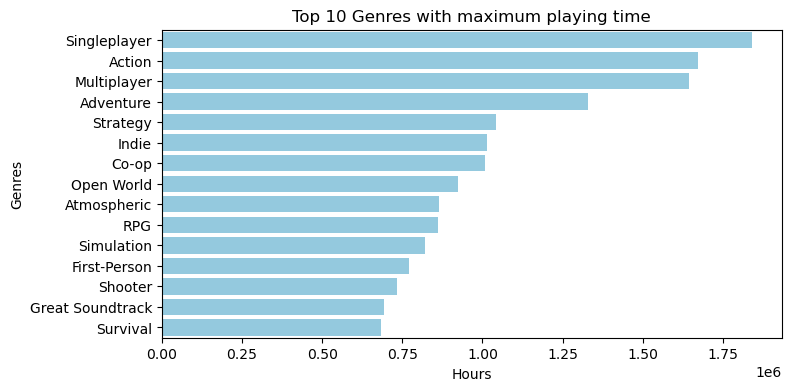

In [51]:
# Aggregating the data for each tag
tag_agg = tags_exploded.groupby('tags').agg({
    'hours': 'sum'
}).reset_index()


# Sorting and selecting the top 10 tags based on the chosen metric
top_tags = tag_agg.sort_values(by="hours", ascending=False).head(15)

# Visualization
plt.figure(figsize=(8, 4))
sns.barplot(x="hours", y='tags', data=top_tags, color='skyblue')
plt.title(f'Top 10 Genres with maximum playing time')
plt.xlabel('Hours')
plt.ylabel('Genres')
plt.show()

We can see that the **Singleplayer** games are mostly played by the user followed by **Action** and then **Multiplayer**.

In [16]:
# Create binary columns for each tag
for tag in all_tags:
    final_data[tag] = final_data['tags'].apply(lambda x: 1 if tag in x else 0)

# Drop the original 'tags' column if needed
final_data.drop(columns=['tags'], inplace=True)

In [17]:
final_data.head()

,is_recommended,hours,user_id,title,win,mac,linux,rating,positive_ratio,user_reviews,price_final,steam_deck,products,reviews,year,month,day,Horror,Twin Stick Shooter,Top-Down Shooter,Villain Protagonist,Difficult,Shooter,Psychological Horror,Isometric,Dark Humor,Top-Down,Dark Comedy,Surreal,Action,Linear,Hand-drawn,Psychological,Atmospheric,Level Editor,1990's,Comedy,Combat Racing,Racing,Classic,Indie,Gore,Retro,Vehicular Combat,Multiplayer,Great Soundtrack,Singleplayer,Arcade,Female Protagonist,FPS,Sci-fi,First-Person,Aliens,Silent Protagonist,Story Rich,Moddable,Adventure,Action-Adventure,PvP,Military,Puzzle,Co-op,Hero Shooter,Team-Based,Class-Based,Old School,Competitive,Fast-Paced,Online Co-Op,Violent,Funny,Mod,Remake,Tactical,eSports,Strategy,Survival,Score Attack,1980s,Assassin,Nostalgia,Space,Cyberpunk,Memes,Platformer,Conspiracy,3D,Cult Classic,Sports,Zombies,Short,Arena Shooter,Open World,Crime,Third Person,Third-Person Shooter,Historical,Drama,Controller,Casual,Nudity,Mature,World War II,War,World War I,Simulation,Sandbox,Dark,Physics,Dystopian,Benchmark,Futuristic,Free to Play,Post-apocalyptic,Pirates,RPG,Naval,Sailing,Economy,Exploration,Trading,Naval Combat,Choose Your Own Adventure,Fighting,NaN,Turn-Based Strategy,Turn-Based,4X,Replay Value,Grand Strategy,Addictive,City Builder,Diplomacy,Alternate History,Fantasy,Dark Fantasy,Swordplay,Magic,Stealth,Multiple Endings,Medieval,Action RPG,Hack and Slash,Immersive Sim,Mystery,Stylized,Resource Management,Management,Local Multiplayer,Base Building,RTS,Real-Time,Pixel Graphics,Tactical RPG,Robots,3D Platformer,Cartoony,Collectathon,3D Vision,Match 3,Underwater,2D,Family Friendly,Western,Bullet Time,Horses,Hacking,Real-Time with Pause,Experimental,Perma Death,Programming,Roguelike,Text-Based,Clicker,Cute,Colorful,Point & Click,Relaxing,America,Realistic,Tanks,Supernatural,Shoot 'Em Up,PvE,Combat,Local Co-Op,Episodic,Space Sim,Flight,Bullet Hell,Cinematic,Survival Horror,Based On A Novel,Immersive,Inventory Management,Demons,Real Time Tactics,Rome,Steampunk,Political,2.5D,Modern,Gothic,Parkour,Puzzle Platformer,Mechs,Snow,Spectacle fighter,Character Action Game,Beat 'em up,Vampire,Heist,Split Screen,Co-op Campaign,Education,Sequel,4 Player Local,Dinosaurs,Automobile Sim,Driving,Mouse only,Sexual Content,Hentai,Side Scroller,Pinball,Trains,Building,Beautiful,Escape Room,Underground,Dungeon Crawler,Psychedelic,Noir,Detective,Character Customization,Choices Matter,Romance,Warhammer 40K,Games Workshop,Time Attack,Blood,Action RTS,Music,Rhythm,Music-Based Procedural Generation,Procedural Generation,Satire,Touch-Friendly,Loot,Metroidvania,Philosophical,Emotional,Narrative,LEGO,Superhero,Comic Book,TrackIR,Jet,VR,Destruction,Soundtrack,Tower Defense,Capitalism,Turn-Based Tactics,Unforgiving,Submarine,Mythology,Werewolves,Time Manipulation,Time Travel,Lovecraftian,Minigames,Cold War,LGBTQ+,Investigation,FMV,Party-Based RPG,Looter Shooter,Epic,Quick-Time Events,Mars,Wargame,Turn-Based Combat,CRPG,Sniper,Ambient,Minimalist,Science,Anime,Football (Soccer),2D Fighter,Cartoon,Hex Grid,Strategy RPG,Parody,God Game,2D Platformer,Hidden Object,Jump Scare,Dog,Roguelite,Crafting,Transportation,Colony Sim,Walking Simulator,Experience,Medical Sim,Farming Sim,Agriculture,Ninja,Souls-like,Mahjong,Interactive Fiction,Board Game,Political Sim,Logic,Narration,Auto Battler,Spaceships,Thriller,Massively Multiplayer,Utilities,Software,Precision Platformer,Hunting,Well-Written,Dragons,Abstract,Politics,Life Sim,Vikings,JRPG,Visual Novel,Party,Mining,Solitaire,Card Game,Tabletop,Typing,Time Management,Action Roguelike,Motocross,Offroad,Motorbike,ATV,Bikes,Electronic Music,Football (American),MMORPG,Dynamic Narration,Automation,Illuminati,Gun Customization,Runner,Traditional Roguelike,Bowling,Kickstarter,Golf,NSFW,On-Rails Shooter,Fishing,Lemmings,Card Battler,Deckbuilding,Asynchronous Multiplayer,Chess,Creature Collector,Artificial Intelligence,Cats,Idler,RPGMaker,MOBA,3D Fighter,GameMaker,Skating,Tr

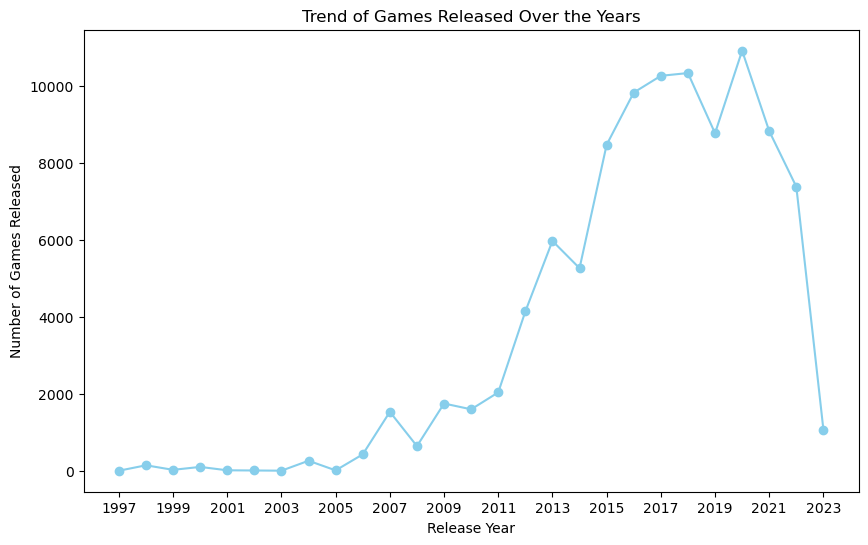

In [18]:
# Count games released each year
games_per_year = final_data['year'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(games_per_year.index, games_per_year.values, marker='o', linestyle='-', color='skyblue')
plt.xlabel('Release Year')
plt.ylabel('Number of Games Released')
plt.title('Trend of Games Released Over the Years')
plt.xticks(range(games_per_year.index.min(), games_per_year.index.max()+1, 2))
plt.show()

From the above plot we can see that the games started to get release more frequently from the year **2014** and then less frequently around the year **2020**.

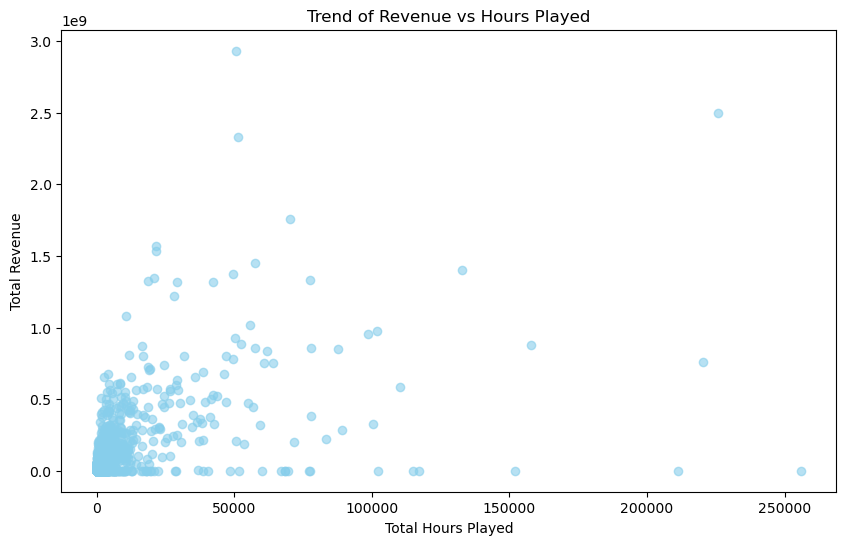

In [19]:
# Calculate the total revenue for each game
final_data['total_revenue'] = final_data['price_final'] * final_data['user_id'].nunique()

# Calculate the total hours played for each game
total_hours_played = final_data.groupby('title')['hours'].sum().reset_index()
total_revenue = final_data.groupby('title')['total_revenue'].sum().reset_index()

# Merge the revenue and hours played data
revenue_vs_hours = total_hours_played.merge(total_revenue, on='title')

# Plot the trend of revenue vs hours played
plt.figure(figsize=(10, 6))
plt.scatter(revenue_vs_hours['hours'], revenue_vs_hours['total_revenue'], color='skyblue', alpha=0.6)
plt.xlabel('Total Hours Played')
plt.ylabel('Total Revenue')
plt.title('Trend of Revenue vs Hours Played')
plt.show()

The plot shows the relationship between the Total Hours of Games Played by Users and the Total Revenue Generated from Game Purchases. Although no clear trend is apparent, it suggests that as playing time increases, so does the revenue.

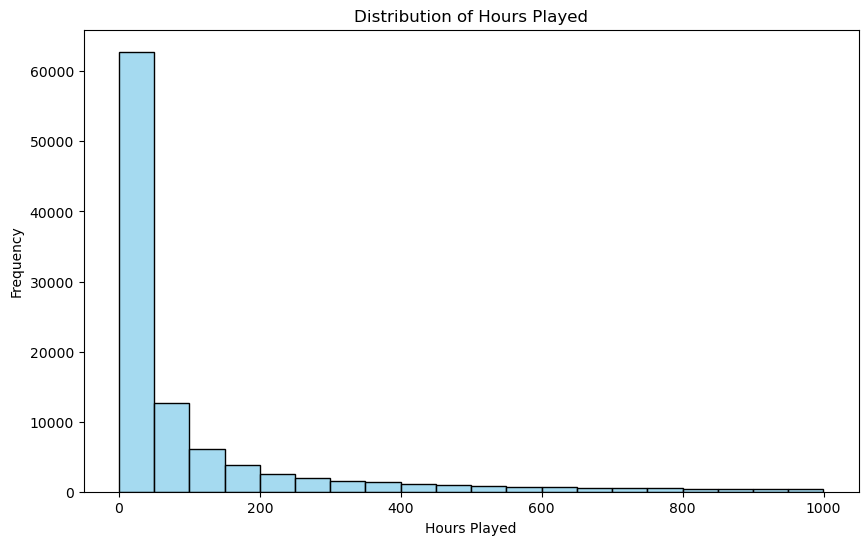

In [20]:
# Visualize the average hours played per user
plt.figure(figsize=(10, 6))
sns.histplot(final_data['hours'], bins=20, color='skyblue')
plt.title('Distribution of Hours Played')
plt.xlabel('Hours Played')
plt.ylabel('Frequency')
plt.show()

From the distribution, it is clearly visible that most of the users' playing time is between **0-100** hours

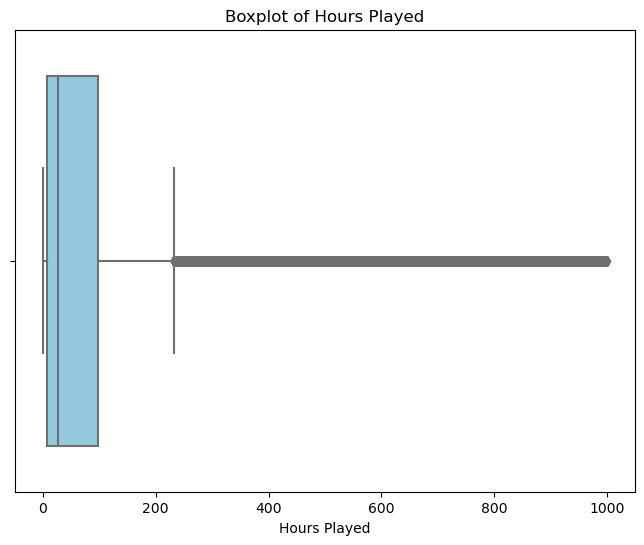

In [21]:
# Visualize outliers for 'hours' column
plt.figure(figsize=(8, 6))
sns.boxplot(x=final_data['hours'],color='skyblue')
plt.title('Boxplot of Hours Played')
plt.xlabel('Hours Played')
plt.show()

From the boxplot we can see that there are many **outliers** from around **250-1000** hours playing time. It might be the users who must be Gamers by profession.

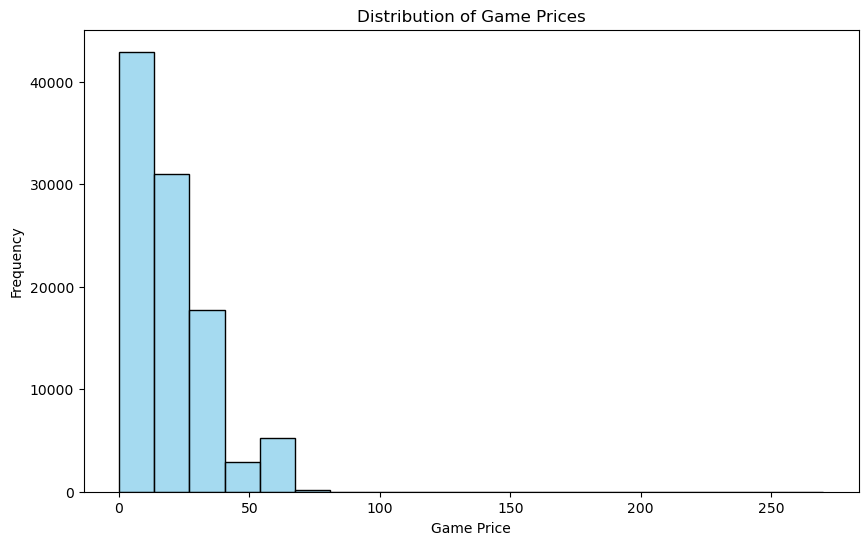

In [22]:
# Visualise the purchase price of games
plt.figure(figsize=(10, 6))
sns.histplot(final_data['price_final'], bins=20,color='skyblue')
plt.title('Distribution of Game Prices')
plt.xlabel('Game Price')
plt.ylabel('Frequency')
plt.show()

The distribution shows the price at which most of the Games are purchased is in between 0 to 50.

When choosing features for machine learning model, it's essential to balance between numerical features that provide measurable data points and categorical features that offer descriptive attributes. This combination ensures that the clustering algorithm can effectively group similar entities based on both quantitative metrics and qualitative traits.

In [24]:
# Select relevant features for clustering
numerical_features = ['user_id', 'positive_ratio', 'user_reviews', 'price_final', 'products', 'reviews',
                       'year', 'month', 'day',
                      'Horror', 'Twin Stick Shooter', 'Top-Down Shooter',
       'Villain Protagonist', 'Difficult', 'Shooter',
       'Psychological Horror', 'Isometric', 'Dark Humor', 'Top-Down',
       'Dark Comedy', 'Surreal', 'Action', 'Linear', 'Hand-drawn',
       'Psychological', 'Atmospheric', 'Level Editor', "1990's", 'Comedy',
       'Combat Racing', 'Racing', 'Classic', 'Indie', 'Gore', 'Retro',
       'Vehicular Combat', 'Multiplayer', 'Great Soundtrack',
       'Singleplayer', 'Arcade', 'Female Protagonist', 'FPS', 'Sci-fi',
       'First-Person', 'Aliens', 'Silent Protagonist', 'Story Rich',
       'Moddable', 'Adventure', 'Action-Adventure', 'PvP', 'Military',
       'Puzzle', 'Co-op', 'Hero Shooter', 'Team-Based', 'Class-Based',
       'Old School', 'Competitive', 'Fast-Paced', 'Online Co-Op',
       'Violent', 'Funny', 'Mod', 'Remake', 'Tactical', 'eSports',
       'Strategy', 'Survival', 'Score Attack', '1980s', 'Assassin',
       'Nostalgia', 'Space', 'Cyberpunk', 'Memes', 'Platformer',
       'Conspiracy', '3D', 'Cult Classic', 'Sports', 'Zombies', 'Short',
       'Arena Shooter', 'Open World', 'Crime', 'Third Person',
       'Third-Person Shooter', 'Historical', 'Drama', 'Controller',
       'Casual', 'Nudity', 'Mature', 'World War II', 'War', 'World War I',
       'Simulation', 'Sandbox', 'Dark', 'Physics', 'Dystopian',
       'Benchmark', 'Futuristic', 'Free to Play', 'Post-apocalyptic',
       'Pirates', 'RPG', 'Naval', 'Sailing', 'Economy', 'Exploration',
       'Trading', 'Naval Combat', 'Choose Your Own Adventure', 'Fighting',
       'Turn-Based Strategy', 'Turn-Based', '4X', 'Replay Value',
       'Grand Strategy', 'Addictive', 'City Builder', 'Diplomacy',
       'Alternate History', 'Fantasy', 'Dark Fantasy', 'Swordplay',
       'Magic', 'Stealth', 'Multiple Endings', 'Medieval', 'Action RPG',
       'Hack and Slash', 'Immersive Sim', 'Mystery', 'Stylized',
       'Resource Management', 'Management', 'Local Multiplayer',
       'Base Building', 'RTS', 'Real-Time', 'Pixel Graphics',
       'Tactical RPG', 'Robots', '3D Platformer', 'Cartoony',
       'Collectathon', '3D Vision', 'Match 3', 'Underwater', '2D',
       'Family Friendly', 'Western', 'Bullet Time', 'Horses', 'Hacking',
       'Real-Time with Pause', 'Experimental', 'Perma Death',
       'Programming', 'Roguelike', 'Text-Based', 'Clicker', 'Cute',
       'Colorful', 'Point & Click', 'Relaxing', 'America', 'Realistic',
       'Tanks', 'Supernatural', "Shoot 'Em Up", 'PvE', 'Combat',
       'Local Co-Op', 'Episodic', 'Space Sim', 'Flight', 'Bullet Hell',
       'Cinematic', 'Survival Horror', 'Based On A Novel', 'Immersive',
       'Inventory Management', 'Demons', 'Real Time Tactics', 'Rome',
       'Steampunk', 'Political', '2.5D', 'Modern', 'Gothic', 'Parkour',
       'Puzzle Platformer', 'Mechs', 'Snow', 'Spectacle fighter',
       'Character Action Game', "Beat 'em up", 'Vampire', 'Heist',
       'Split Screen', 'Co-op Campaign', 'Education', 'Sequel',
       '4 Player Local', 'Dinosaurs', 'Automobile Sim', 'Driving',
       'Mouse only', 'Sexual Content', 'Hentai', 'Side Scroller',
       'Pinball', 'Trains', 'Building', 'Beautiful', 'Escape Room',
       'Underground', 'Dungeon Crawler', 'Psychedelic', 'Noir',
       'Detective', 'Character Customization', 'Choices Matter',
       'Romance', 'Warhammer 40K', 'Games Workshop', 'Time Attack',
       'Blood', 'Action RTS', 'Music', 'Rhythm',
       'Music-Based Procedural Generation', 'Procedural Generation',
       'Satire', 'Touch-Friendly', 'Loot', 'Metroidvania',
       'Philosophical', 'Emotional', 'Narrative', 'LEGO', 'Superhero',
       'Comic Book', 'TrackIR', 'Jet', 'VR', 'Destruction', 'Soundtrack',
       'Tower Defense', 'Capitalism', 'Turn-Based Tactics', 'Unforgiving',
       'Submarine', 'Mythology', 'Werewolves', 'Time Manipulation',
       'Time Travel', 'Lovecraftian', 'Minigames', 'Cold War', 'LGBTQ+',
       'Investigation', 'FMV', 'Party-Based RPG', 'Looter Shooter',
       'Epic', 'Quick-Time Events', 'Mars', 'Wargame',
       'Turn-Based Combat', 'CRPG', 'Sniper', 'Ambient', 'Minimalist',
       'Science', 'Anime', 'Football (Soccer)', '2D Fighter', 'Cartoon',
       'Hex Grid', 'Strategy RPG', 'Parody', 'God Game', '2D Platformer',
       'Hidden Object', 'Jump Scare', 'Dog', 'Roguelite', 'Crafting',
       'Transportation', 'Colony Sim', 'Walking Simulator', 'Experience',
       'Medical Sim', 'Farming Sim', 'Agriculture', 'Ninja', 'Souls-like',
       'Mahjong', 'Interactive Fiction', 'Board Game', 'Political Sim',
       'Logic', 'Narration', 'Auto Battler', 'Spaceships', 'Thriller',
       'Massively Multiplayer', 'Utilities', 'Software',
       'Precision Platformer', 'Hunting', 'Well-Written', 'Dragons',
       'Abstract', 'Politics', 'Life Sim', 'Vikings', 'JRPG',
       'Visual Novel', 'Party', 'Mining', 'Solitaire', 'Card Game',
       'Tabletop', 'Typing', 'Time Management', 'Action Roguelike',
       'Motocross', 'Offroad', 'Motorbike', 'ATV', 'Bikes',
       'Electronic Music', 'Football (American)', 'MMORPG',
       'Dynamic Narration', 'Automation', 'Illuminati',
       'Gun Customization', 'Runner', 'Traditional Roguelike', 'Bowling',
       'Kickstarter', 'Golf', 'NSFW', 'On-Rails Shooter', 'Fishing',
       'Lemmings', 'Card Battler', 'Deckbuilding',
       'Asynchronous Multiplayer', 'Chess', 'Creature Collector',
       'Artificial Intelligence', 'Cats', 'Idler', 'RPGMaker', 'MOBA',
       '3D Fighter', 'GameMaker', 'Skating', 'Transhumanism',
       'Voice Control', 'Conversation', 'Game Development',
       'Design & Illustration', 'Web Publishing', 'Nature', 'Movie',
       'Documentary', 'Feature Film', 'Open World Survival Craft',
       'Lore-Rich', 'Grid-Based Movement', 'Martial Arts', 'Sokoban',
       'Roguevania', 'Reboot', 'Cooking', 'Nonlinear', 'Early Access',
       'Crowdfunded', 'Intentionally Awkward Controls', 'Pool', 'Snooker',
       'Dating Sim', 'Tutorial', 'Basketball', 'Farming',
       'Dungeons & Dragons', 'Trivia', 'Party Game', 'Job Simulator',
       'Animation & Modeling', 'Voxel', 'Social Deduction', '6DOF',
       'Wrestling', 'Video Production', 'Mystery Dungeon', 'Faith',
       'Photo Editing', 'Musou', 'Audio Production', 'Trading Card Game',
       'Word Game', 'Battle Royale', 'Steam Machine', 'Otome',
       'Skateboarding', 'Archery', 'Spelling', 'Software Training',
       'Cozy', 'Wholesome', 'Boxing', 'Roguelike Deckbuilder', 'Skiing',
       'Boss Rush', 'BMX', 'Gaming', 'Hardware', 'Mini Golf', 'Gambling',
       'Outbreak Sim', 'Tennis', 'Cricket', 'Hockey', 'Baseball',
       'Snowboarding', 'Foreign', 'Asymmetric VR', 'Electronic',
       '360 Video', 'Cycling', 'Fox', 'Shop Keeper', 'Hobby Sim',
       '8-bit Music', 'Rock Music', 'Volleyball', 'Coding',
       'Instrumental Music']
categorical_features = ['is_recommended', 'win', 'mac', 'linux', 'steam_deck', 'rating']

### Predicting User Gameplay Hours Using A Linear Regression Model

Here we are preparing the dataset for training the Linear Regression model by separating it into features and target, ensuring consistency in feature names, transforming the target variable to handle skewness, and setting up a preprocessing pipeline where it standardizes numerical features with 'StandardScaler()' and converts categorical features into binary format using 'OneHotEncoder()'. This preprocessing is crucial to improve the performance and accuracy of the model.

In [25]:
# Split data into features and target
X = final_data.drop(columns=['hours'])
y = final_data['hours']

# Ensure all column names are strings
X.columns = X.columns.astype(str)

# Apply logarithmic transformation to the target variable
y_log = np.log1p(y)  # Use log1p to handle zero values


# Preprocessing pipeline for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

It sets up and trains a Linear Regression model using a pipeline that includes data preprocessing  and model training. The pipeline ensures that data preprocessing steps are applied consistently, and the model is trained effectively. Further, the dataset is split into training (70%) and testing (30%) sets to enable proper evaluation of the model's performance, and the training process is executed to fit the model to the training data.

In [26]:

# Define the model pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.3, random_state=56)

# Fit the model pipeline
model_pipeline.fit(X_train, y_train)



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['user_id', 'positive_ratio',
                                                   'user_reviews',
                                                   'price_final', 'products',
                                                   'reviews', 'year', 'month',
                                                   'day', 'Horror',
                                                   'Twin Stick Shooter',
                                                   'Top-Down Shooter',
                                                   'Villain Protagonist',
                                                   'Difficult', 'Shooter',
                                                   'Psychological Horror',
                                                   'Isometric', 'Dark Humor',
                                                   'Top-Down', 'Dark Comedy',
                                                   'Surreal', 'Action',
                                                   'Linear', 'Hand-drawn',
                                                   'Psychological',
                                                   'Atmospheric',
                                                   'Level Editor', "1990's",
                                                   'Comedy', 'Combat Racing', ...]),
                                                 ('cat', OneHotEncoder(),
                                                  ['is_recommended', 'win',
                                                   'mac', 'linux', 'steam_deck',
                                                   'rating'])])),
                ('regressor', LinearRegression())])

In [27]:

# Predict on training and test data
y_train_pred = model_pipeline.predict(X_train)
y_test_pred = model_pipeline.predict(X_test)

# Calculate Mean Squared Error (MSE) and Root Mean Squared Error (RMSE)
train_mse = mean_squared_error(np.expm1(y_train), np.expm1(y_train_pred))  # Transform back using np.expm1 to invert log1p
test_mse = mean_squared_error(np.expm1(y_test), np.expm1(y_test_pred))  # Transform back using np.expm1 to invert log1p

train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

# Calculate Mean Absolute Error (MAE)
train_mae = mean_absolute_error(np.expm1(y_train), np.expm1(y_train_pred))  # Transform back using np.expm1 to invert log1p
test_mae = mean_absolute_error(np.expm1(y_test), np.expm1(y_test_pred))  # Transform back using np.expm1 to invert log1p

print(f'Training Root Mean Squared Error (RMSE): {train_rmse}')
print(f'Test Root Mean Squared Error (RMSE): {test_rmse}')

print(f'Training Mean Absolute Error (MAE): {train_mae}')
print(f'Test Mean Absolute Error (MAE): {test_mae}')

Training Root Mean Squared Error (RMSE): 190.8777068029933
Test Root Mean Squared Error (RMSE): 189.40323568622568
Training Mean Absolute Error (MAE): 86.67220684849623
Test Mean Absolute Error (MAE): 85.78706653127736


The linear regression model has an RMSE of 190.88 on the training data and 189.40 on the test data, indicating similar error magnitudes for both. The MAE values are 86.67 for the training data and 85.79 for the test data, showing consistent average absolute errors. These results suggest that the model has learned the underlying pattern in the data well and generalizes effectively to new, unseen data.

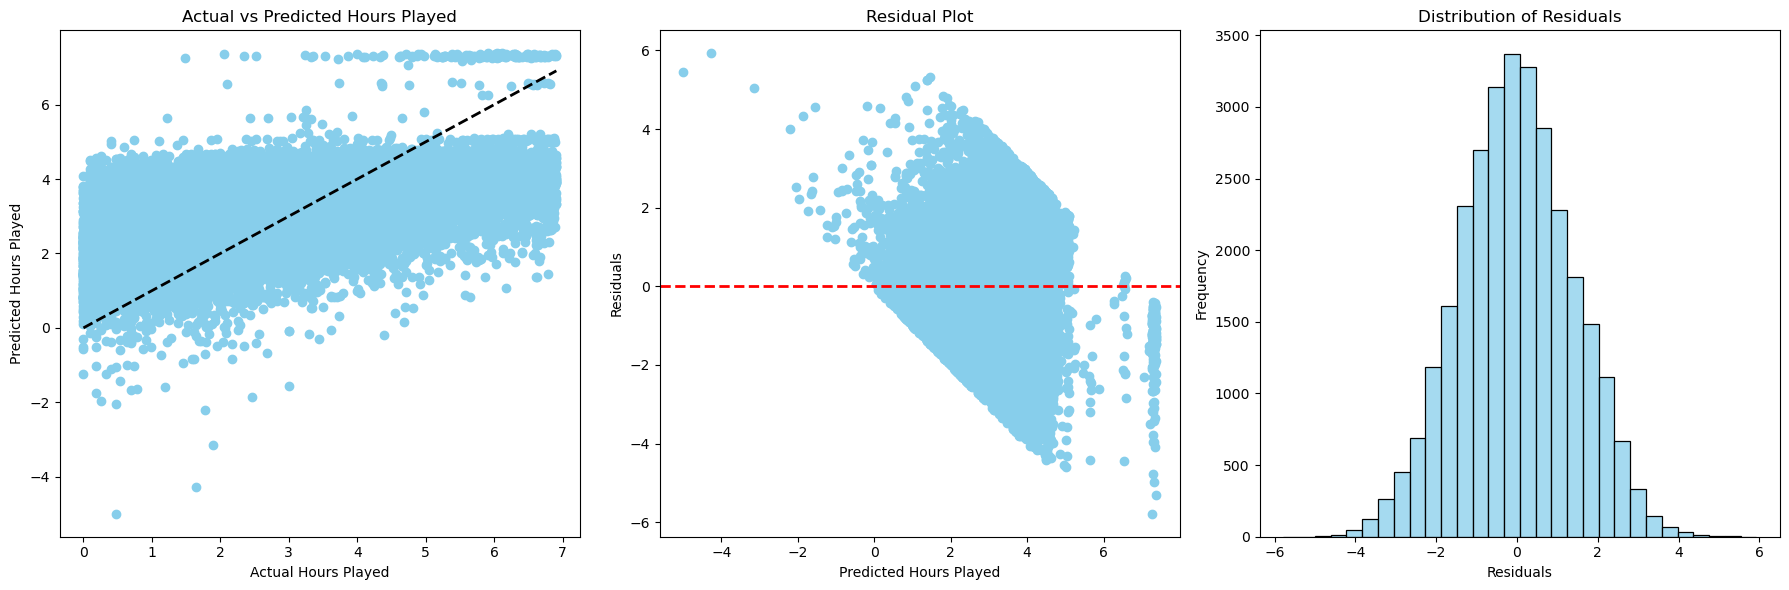

In [28]:
# Calculate residuals
residuals = y_test - y_test_pred

# Create a figure and axis array for subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plotting actual vs predicted values for test set
axs[0].scatter(y_test, y_test_pred, color='skyblue')
axs[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Plotting the diagonal line
axs[0].set_xlabel('Actual Hours Played')
axs[0].set_ylabel('Predicted Hours Played')
axs[0].set_title('Actual vs Predicted Hours Played')

# Plotting residuals
axs[1].scatter(y_test_pred, residuals, color='skyblue')
axs[1].axhline(y=0, color='r', linestyle='--', lw=2)  # Adding a horizontal line at residual = 0
axs[1].set_xlabel('Predicted Hours Played')
axs[1].set_ylabel('Residuals')
axs[1].set_title('Residual Plot')

# Distribution plot of residuals
sns.histplot(residuals, bins=30, ax=axs[2], color='skyblue')
axs[2].set_xlabel('Residuals')
axs[2].set_ylabel('Frequency')
axs[2].set_title('Distribution of Residuals')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

The plot compares how well a machine learning model predicts game playtime. Points near the diagonal line indicate accurate predictions, while those away from it show errors. The residuals plot displays prediction errors: points above the line mean underestimation, and below mean overestimation. These visuals help assess that the model might be overfitting. The distribution of the residuals shows the prediction of the model is more scattered and less consistent.


### Using L1 Regularization to Address Overfitting in Linear Regression

After predicting the values by Linear Regression Model, let's check whether L1 regularization leads to more accurate results. Lasso regression introduces regularization by adding a penalty term to the model's loss function, which encourages simpler and more interpretable models by shrinking the coefficients of less important features to zero. This regularization helps mitigate overfitting and enhances the model's ability to generalize to new data, as evidenced by the improved predictive performance in this case. 

In [29]:
# Define the model pipeline with Lasso regression
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Lasso(alpha=0.1))  # Lasso Regression with an alpha value of 0.1
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.3, random_state=56)

# Fit the model pipeline
model_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['user_id', 'positive_ratio',
                                                   'user_reviews',
                                                   'price_final', 'products',
                                                   'reviews', 'year', 'month',
                                                   'day', 'Horror',
                                                   'Twin Stick Shooter',
                                                   'Top-Down Shooter',
                                                   'Villain Protagonist',
                                                   'Difficult', 'Shooter',
                                                   'Psychological Horror',
                                                   'Isometric', 'Dark Humor',
                                                   'Top-Down', 'Dark Comedy',
                                                   'Surreal', 'Action',
                                                   'Linear', 'Hand-drawn',
                                                   'Psychological',
                                                   'Atmospheric',
                                                   'Level Editor', "1990's",
                                                   'Comedy', 'Combat Racing', ...]),
                                                 ('cat', OneHotEncoder(),
                                                  ['is_recommended', 'win',
                                                   'mac', 'linux', 'steam_deck',
                                                   'rating'])])),
                ('regressor', Lasso(alpha=0.1))])

In [30]:
# Predict on training and test data
y_train_pred = model_pipeline.predict(X_train)
y_test_pred = model_pipeline.predict(X_test)

# Calculate Mean Squared Error (MSE) and Root Mean Squared Error (RMSE)
train_mse = mean_squared_error(np.expm1(y_train), np.expm1(y_train_pred))  # Transform back using np.expm1 to invert log1p
test_mse = mean_squared_error(np.expm1(y_test), np.expm1(y_test_pred))  # Transform back using np.expm1 to invert log1p

train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

# Calculate Mean Absolute Error (MAE)
train_mae = mean_absolute_error(np.expm1(y_train), np.expm1(y_train_pred))  # Transform back using np.expm1 to invert log1p
test_mae = mean_absolute_error(np.expm1(y_test), np.expm1(y_test_pred))  # Transform back using np.expm1 to invert log1p

print(f'Training Root Mean Squared Error (RMSE): {train_rmse}')
print(f'Test Root Mean Squared Error (RMSE): {test_rmse}')

print(f'Training Mean Absolute Error (MAE): {train_mae}')
print(f'Test Mean Absolute Error (MAE): {test_mae}')

Training Root Mean Squared Error (RMSE): 181.92250915974014
Test Root Mean Squared Error (RMSE): 181.1452327546934
Training Mean Absolute Error (MAE): 85.13033939374826
Test Mean Absolute Error (MAE): 84.11164362640683


After applying Lasso regression with an alpha value of 0.1 to our model predicting hours played, improvements were observed in performance metrics. The Root Mean Squared Error (RMSE) decreased from 190.88 to 181.15, indicating better accuracy in predicting numerical values. Similarly, the Mean Absolute Error (MAE) improved from 86.67 to 84.11, reflecting reduced average prediction errors. Hence in this case we can definetely improve the accuracy and robustness of our hours played prediction model.

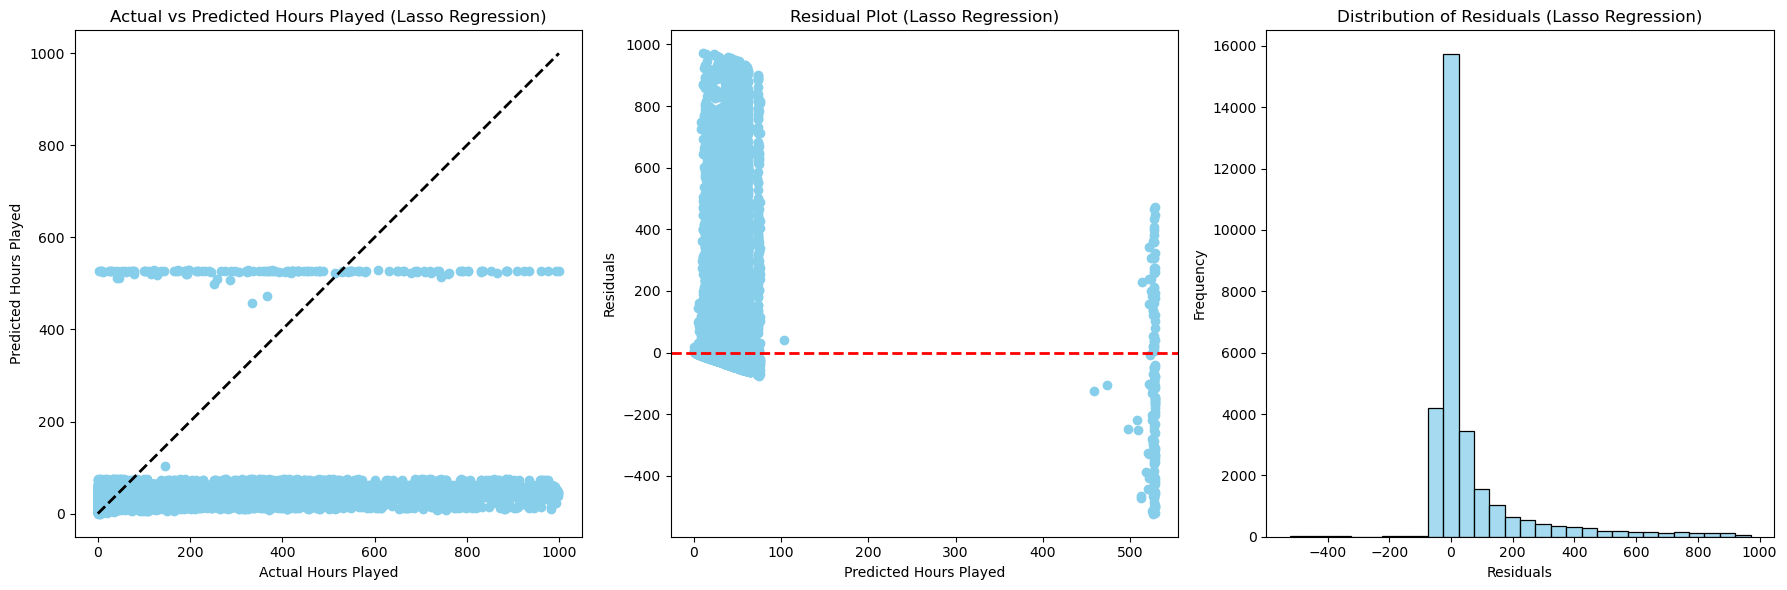

In [31]:
# Transform y_test and y_test_pred back to original scale
y_test_orig = np.expm1(y_test)
y_pred_orig = np.expm1(y_test_pred)

# Calculate residuals for Lasso regression
residuals_lasso = y_test_orig - y_pred_orig

# Create a figure and axis array for subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plotting actual vs predicted values for test set 
axs[0].scatter(y_test_orig,y_pred_orig, color='skyblue')
axs[0].plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], 'k--', lw=2)  # Plotting the diagonal line
axs[0].set_xlabel('Actual Hours Played')
axs[0].set_ylabel('Predicted Hours Played')
axs[0].set_title('Actual vs Predicted Hours Played (Lasso Regression)')

# Plotting residuals (Lasso Regression)
axs[1].scatter(y_pred_orig, residuals_lasso, color='skyblue')
axs[1].axhline(y=0, color='r', linestyle='--', lw=2)  # Adding a horizontal line at residual = 0
axs[1].set_xlabel('Predicted Hours Played')
axs[1].set_ylabel('Residuals')
axs[1].set_title('Residual Plot (Lasso Regression)')

# Distribution plot of residuals (Lasso Regression)
sns.histplot(residuals_lasso, bins=30, ax=axs[2], color='skyblue')
axs[2].set_xlabel('Residuals')
axs[2].set_ylabel('Frequency')
axs[2].set_title('Distribution of Residuals (Lasso Regression)')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()


If we compare the plots from the linear regression model, we notice that the distribution of residuals has narrowed, indicating that the model's predictions are closer to the actual values. This suggests a reduction in overfitting, meaning the model is generalizing better to new data and making more accurate predictions overall.

### Comparing KNN Regression for Improved Results 

Applying Lasso regression with an alpha value of 0.1 has led to a more accurate model for predicting hours played in our dataset. Now, let's check whether KNN regression makes any difference in the model.

In [32]:
# Define the model pipeline with KNN Regressor
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', KNeighborsRegressor(n_neighbors=5))  # KNN Regressor as the regressor
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.3, random_state=56)

# Fit the model pipeline
model_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['user_id', 'positive_ratio',
                                                   'user_reviews',
                                                   'price_final', 'products',
                                                   'reviews', 'year', 'month',
                                                   'day', 'Horror',
                                                   'Twin Stick Shooter',
                                                   'Top-Down Shooter',
                                                   'Villain Protagonist',
                                                   'Difficult', 'Shooter',
                                                   'Psychological Horror',
                                                   'Isometric', 'Dark Humor',
                                                   'Top-Down', 'Dark Comedy',
                                                   'Surreal', 'Action',
                                                   'Linear', 'Hand-drawn',
                                                   'Psychological',
                                                   'Atmospheric',
                                                   'Level Editor', "1990's",
                                                   'Comedy', 'Combat Racing', ...]),
                                                 ('cat', OneHotEncoder(),
                                                  ['is_recommended', 'win',
                                                   'mac', 'linux', 'steam_deck',
                                                   'rating'])])),
                ('regressor', KNeighborsRegressor())])

In [33]:
# Predict on training and test data
y_train_pred = model_pipeline.predict(X_train)
y_test_pred = model_pipeline.predict(X_test)

# Calculate Mean Squared Error (MSE) and Root Mean Squared Error (RMSE)
train_mse = mean_squared_error(np.expm1(y_train), np.expm1(y_train_pred))  # Transform back using np.expm1 to invert log1p
test_mse = mean_squared_error(np.expm1(y_test), np.expm1(y_test_pred))  # Transform back using np.expm1 to invert log1p

train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

# Calculate Mean Absolute Error (MAE)
train_mae = mean_absolute_error(np.expm1(y_train), np.expm1(y_train_pred))  # Transform back using np.expm1 to invert log1p
test_mae = mean_absolute_error(np.expm1(y_test), np.expm1(y_test_pred))  # Transform back using np.expm1 to invert log1p

print(f'Training Root Mean Squared Error (RMSE): {train_rmse}')
print(f'Test Root Mean Squared Error (RMSE): {test_rmse}')

print(f'Training Mean Absolute Error (MAE): {train_mae}')
print(f'Test Mean Absolute Error (MAE): {test_mae}')

Training Root Mean Squared Error (RMSE): 144.7776374312887
Test Root Mean Squared Error (RMSE): 161.6929805547517
Training Mean Absolute Error (MAE): 67.15957648533256
Test Mean Absolute Error (MAE): 78.68838284006495


The RMSE for the KNN Regressor (161.6930) is lower than that of Lasso Regression (181.1452), indicating that the KNN model generally makes predictions that are closer to the actual values. A lower RMSE suggests better predictive accuracy. Similarly, the MAE for the KNN Regressor (78.6884) is lower compared to Lasso Regression (84.1116). This indicates that, on average, the predictions from the KNN model are closer to the true values.

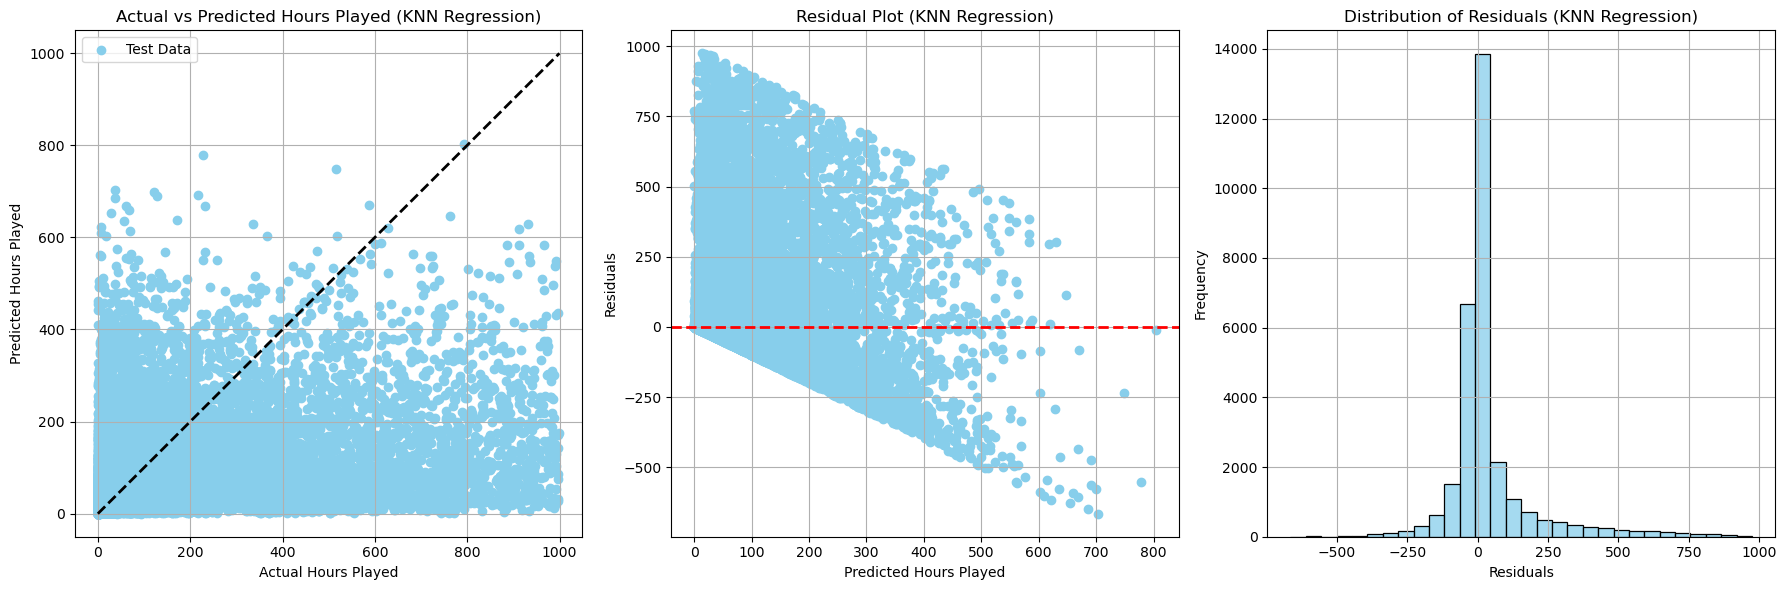

In [34]:
# Transform y_test and y_test_pred back to original scale
y_test_orig = np.expm1(y_test)
y_pred_orig = np.expm1(y_test_pred)


residuals = y_test_orig - y_pred_orig
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plotting actual vs predicted values for test set
axs[0].scatter(y_test_orig, y_pred_orig, color='skyblue', label='Test Data')
axs[0].plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], 'k--', lw=2)  # Plotting the diagonal line
axs[0].set_xlabel('Actual Hours Played')
axs[0].set_ylabel('Predicted Hours Played')
axs[0].set_title('Actual vs Predicted Hours Played (KNN Regression)')
axs[0].legend()
axs[0].grid(True)

# Plotting residuals
axs[1].scatter(y_pred_orig, residuals, color='skyblue')
axs[1].axhline(y=0, color='r', linestyle='--', lw=2)  # Adding a horizontal line at residual = 0
axs[1].set_xlabel('Predicted Hours Played')
axs[1].set_ylabel('Residuals')
axs[1].set_title('Residual Plot (KNN Regression)')
axs[1].grid(True)

# Distribution plot of residuals
sns.histplot(residuals, bins=30, ax=axs[2], color='skyblue')
axs[2].set_xlabel('Residuals')
axs[2].set_ylabel('Frequency')
axs[2].set_title('Distribution of Residuals (KNN Regression)')
axs[2].grid(True)


plt.tight_layout()
plt.show()

The KNN model performed well compared to the Linear regression model and the plot also depicts the same.

## Exploring Game Recommendations with K-means Clustering

### K-Means Clustering

K-means clustering groups data into 'k' clusters by iteratively assigning points to the nearest centroid and updating centroids until clusters are formed. It's used for organizing data into groups based on similarity, aiding tasks like customer segmentation and data analysis.

Let's prepare numerical and categorical features separately using pipelines and combine them into a unified preprocessor using ColumnTransformer. This then transforms the input data (final_data) into X_processed, ensuring all features are suitably formatted for machine learning models. This preprocessing is crucial for ensuring that the data is in a suitable format and scaled for effective model training and evaluation.

In [35]:
# Preprocessing pipeline for numerical and categorical features
numerical_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing pipelines
preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features)
])


# Fit and transform data
X_processed = preprocessor.fit_transform(final_data[numerical_features + categorical_features])

The silhouette score helps finding the optimal number of clusters by identifing the most distinct and well-separated groups in data, improving clustering accuracy and data understanding. The function find_optimal_clusters uses K-means clustering to find the best number of clusters (k) for a dataset, final_data, based on silhouette scores. It tests different cluster sizes, calculates silhouette scores for each, and returns these scores. This method helps determine the most suitable number of clusters by evaluating how well data points fit into their clusters. Adjusting max_clusters_to_try allows customization based on dataset complexity and computing capabilities for optimal clustering results.

In [36]:
# Function for calculating optimal number of clusters using silhouette score
def find_optimal_clusters(final_data, max_clusters):
    silhouette_scores = []
    for k in range(2, max_clusters+1):
        kmeans = KMeans(n_clusters=k, random_state=56)
        cluster_labels = kmeans.fit_predict(final_data)
        silhouette_avg = silhouette_score(final_data, cluster_labels)
        silhouette_scores.append(silhouette_avg)
        print(f"For n_clusters={k}, the silhouette score is {silhouette_avg:.4f}")
    return silhouette_scores

# Determine the optimal number of clusters
max_clusters_to_try = 10
silhouette_scores = find_optimal_clusters(X_processed, max_clusters_to_try)

For n_clusters=2, the silhouette score is 0.2963
For n_clusters=3, the silhouette score is 0.2971
For n_clusters=4, the silhouette score is 0.2838
For n_clusters=5, the silhouette score is 0.2976
For n_clusters=6, the silhouette score is 0.2975
For n_clusters=7, the silhouette score is 0.2953
For n_clusters=8, the silhouette score is 0.3036
For n_clusters=9, the silhouette score is 0.2973
For n_clusters=10, the silhouette score is 0.2959


In [37]:
# Choose the optimal number of clusters based on the silhouette score
optimal_num_clusters = silhouette_scores.index(max(silhouette_scores)) + 2  
print(f"Optimal number of clusters based on silhouette score: {optimal_num_clusters}")

Optimal number of clusters based on silhouette score: 8


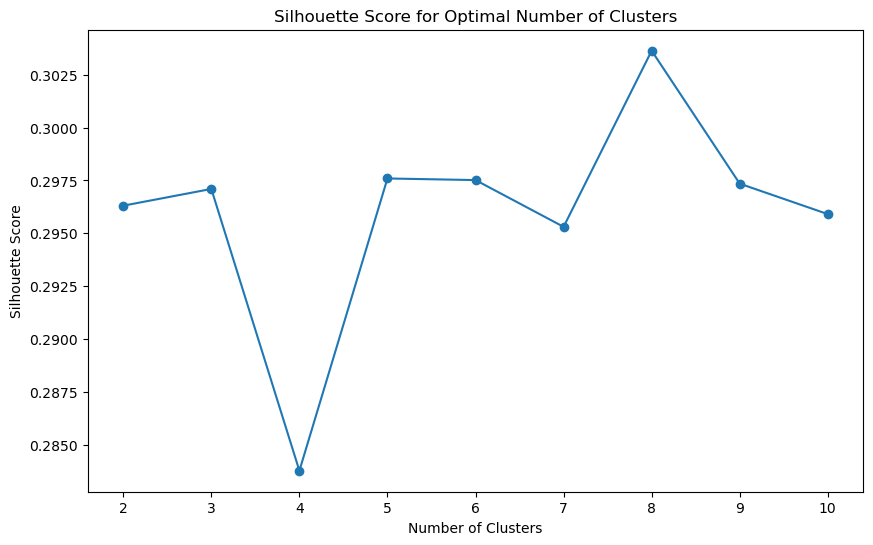

In [38]:
# Plotting the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, max_clusters_to_try + 1), silhouette_scores, marker='o', linestyle='-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal Number of Clusters')
plt.xticks(range(2, max_clusters_to_try + 1))
plt.show()

The plot visualizes the silhouette scores computed for different numbers of clusters (ranging from 2 to max_clusters_to_try). The goal of this plot is to identify the optimal number of clusters where the silhouette score is highest. 

In [39]:

# Apply k-means clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_num_clusters, random_state=67)
final_data['cluster'] = kmeans.fit_predict(X_processed)

The code applies K-means clustering to final_data with an optimal number of clusters that is optimal_num_clusters. The algorithm assigns each data point to a cluster, and results are stored in final_data['cluster']. This helps organize the data into meaningful groups based on their features.

In [40]:
final_data.head()

,is_recommended,hours,user_id,title,win,mac,linux,rating,positive_ratio,user_reviews,price_final,steam_deck,products,reviews,year,month,day,Horror,Twin Stick Shooter,Top-Down Shooter,Villain Protagonist,Difficult,Shooter,Psychological Horror,Isometric,Dark Humor,Top-Down,Dark Comedy,Surreal,Action,Linear,Hand-drawn,Psychological,Atmospheric,Level Editor,1990's,Comedy,Combat Racing,Racing,Classic,Indie,Gore,Retro,Vehicular Combat,Multiplayer,Great Soundtrack,Singleplayer,Arcade,Female Protagonist,FPS,Sci-fi,First-Person,Aliens,Silent Protagonist,Story Rich,Moddable,Adventure,Action-Adventure,PvP,Military,Puzzle,Co-op,Hero Shooter,Team-Based,Class-Based,Old School,Competitive,Fast-Paced,Online Co-Op,Violent,Funny,Mod,Remake,Tactical,eSports,Strategy,Survival,Score Attack,1980s,Assassin,Nostalgia,Space,Cyberpunk,Memes,Platformer,Conspiracy,3D,Cult Classic,Sports,Zombies,Short,Arena Shooter,Open World,Crime,Third Person,Third-Person Shooter,Historical,Drama,Controller,Casual,Nudity,Mature,World War II,War,World War I,Simulation,Sandbox,Dark,Physics,Dystopian,Benchmark,Futuristic,Free to Play,Post-apocalyptic,Pirates,RPG,Naval,Sailing,Economy,Exploration,Trading,Naval Combat,Choose Your Own Adventure,Fighting,NaN,Turn-Based Strategy,Turn-Based,4X,Replay Value,Grand Strategy,Addictive,City Builder,Diplomacy,Alternate History,Fantasy,Dark Fantasy,Swordplay,Magic,Stealth,Multiple Endings,Medieval,Action RPG,Hack and Slash,Immersive Sim,Mystery,Stylized,Resource Management,Management,Local Multiplayer,Base Building,RTS,Real-Time,Pixel Graphics,Tactical RPG,Robots,3D Platformer,Cartoony,Collectathon,3D Vision,Match 3,Underwater,2D,Family Friendly,Western,Bullet Time,Horses,Hacking,Real-Time with Pause,Experimental,Perma Death,Programming,Roguelike,Text-Based,Clicker,Cute,Colorful,Point & Click,Relaxing,America,Realistic,Tanks,Supernatural,Shoot 'Em Up,PvE,Combat,Local Co-Op,Episodic,Space Sim,Flight,Bullet Hell,Cinematic,Survival Horror,Based On A Novel,Immersive,Inventory Management,Demons,Real Time Tactics,Rome,Steampunk,Political,2.5D,Modern,Gothic,Parkour,Puzzle Platformer,Mechs,Snow,Spectacle fighter,Character Action Game,Beat 'em up,Vampire,Heist,Split Screen,Co-op Campaign,Education,Sequel,4 Player Local,Dinosaurs,Automobile Sim,Driving,Mouse only,Sexual Content,Hentai,Side Scroller,Pinball,Trains,Building,Beautiful,Escape Room,Underground,Dungeon Crawler,Psychedelic,Noir,Detective,Character Customization,Choices Matter,Romance,Warhammer 40K,Games Workshop,Time Attack,Blood,Action RTS,Music,Rhythm,Music-Based Procedural Generation,Procedural Generation,Satire,Touch-Friendly,Loot,Metroidvania,Philosophical,Emotional,Narrative,LEGO,Superhero,Comic Book,TrackIR,Jet,VR,Destruction,Soundtrack,Tower Defense,Capitalism,Turn-Based Tactics,Unforgiving,Submarine,Mythology,Werewolves,Time Manipulation,Time Travel,Lovecraftian,Minigames,Cold War,LGBTQ+,Investigation,FMV,Party-Based RPG,Looter Shooter,Epic,Quick-Time Events,Mars,Wargame,Turn-Based Combat,CRPG,Sniper,Ambient,Minimalist,Science,Anime,Football (Soccer),2D Fighter,Cartoon,Hex Grid,Strategy RPG,Parody,God Game,2D Platformer,Hidden Object,Jump Scare,Dog,Roguelite,Crafting,Transportation,Colony Sim,Walking Simulator,Experience,Medical Sim,Farming Sim,Agriculture,Ninja,Souls-like,Mahjong,Interactive Fiction,Board Game,Political Sim,Logic,Narration,Auto Battler,Spaceships,Thriller,Massively Multiplayer,Utilities,Software,Precision Platformer,Hunting,Well-Written,Dragons,Abstract,Politics,Life Sim,Vikings,JRPG,Visual Novel,Party,Mining,Solitaire,Card Game,Tabletop,Typing,Time Management,Action Roguelike,Motocross,Offroad,Motorbike,ATV,Bikes,Electronic Music,Football (American),MMORPG,Dynamic Narration,Automation,Illuminati,Gun Customization,Runner,Traditional Roguelike,Bowling,Kickstarter,Golf,NSFW,On-Rails Shooter,Fishing,Lemmings,Card Battler,Deckbuilding,Asynchronous Multiplayer,Chess,Creature Collector,Artificial Intelligence,Cats,Idler,RPGMaker,MOBA,3D Fighter,GameMaker,Skating,Tr

## Game Recommendation on the basis of User ID

The function recommend_games_for_user(user_id) is designed to provide personalized game recommendations based on a user's preferences and clustering of similar users. Initially, it identifies which cluster the user belongs to by looking up their user_id in the dataset. It then filters out other users' data to focus only on those within the same cluster. Next, games are sorted primarily by rating in descending order (highest ratings first) and secondarily by hours played in ascending order (least played first). This sorting ensures that recommended games are not only highly rated but also less commonly played within the user's cluster, offering a potentially novel gaming experience. Optionally, additional filters such as game genres or platforms can be applied to further refine the recommendations. Finally, the function selects the top N games (typically 10) from the sorted list to present to the user, aiming to enhance their gaming enjoyment through tailored suggestions aligned with their cluster's preferences.

In [52]:
# Function to recommend games for a given user ID
def recommend_games_for_user(user_id):
    # Find the cluster for the given user
    user_cluster = final_data[final_data['user_id'] == user_id]['cluster'].values[0]
    
    # Filter data for users in the same cluster
    cluster_data = final_data[final_data['cluster'] == user_cluster]
    
    # Sort games by rating (higher rating first) and by hours played (lower hours first)
    recommended_games = cluster_data.sort_values(by=['rating', 'hours'], ascending=[False, True])
    
    # Select top 10 games to recommend
    top_n = 10
    recommended_games = recommended_games.head(top_n)['title'].tolist()
    
    return recommended_games


In [53]:
# Example of recommending games for a specific user
user_id = 5225242  # Replace with the user ID you want to recommend games for
recommended_games = recommend_games_for_user(user_id)

print(f"Recommended games for user {user_id}:")
for idx, game in enumerate(recommended_games, start=1):
    print(f"{idx}. {game}")

Recommended games for user 5225242:
1. Counter-Strike: Condition Zero
2. Counter-Strike: Condition Zero
3. Counter-Strike: Condition Zero
4. Half-Life 2: Lost Coast
5. Half-Life 2: Lost Coast
6. The Ship: Murder Party
7. Peggle Extreme
8. Grand Theft Auto 2
9. Zombie Panic! Source
10. The Witcher: Enhanced Edition Director's Cut


## Result

We analysed our dataset using 3 different models, Linear Regression, Lasso Regression & KNN and found that the  K-Nearest Neighbors (KNN) works best in this case. Though Lasso model showed strengths in getting intricate data patterns, it also had higher error extents. We also applied clustering methods to classify users with similar interests and found that this way, we can retrieve even more insights from the dataset such as distinct behavior patterns. Overall our analysis enabled us to offer personalized game recommendations tailored to users with similar preferences.

## Conclusion

The KNN model is the best choice for predicting game playtime because it is more accurate. However, it takes more time to compute and can be affected by unnecessary features. Lasso Regression helps pick important features but assumes a simple relationship between data points, which may not always be true. Overall, KNN's accuracy makes it the preferred model despite its drawbacks.

Clustering analysis helps us understand user behavior better and make personalized game recommendations. By grouping users with similar gaming habits, we can suggest games that they are more likely to enjoy, improving user satisfaction and engagement.create a classification problem to predict whether the games will be played for more that 40 hours by the user 